<a href="https://colab.research.google.com/github/Deng0518/ANN/blob/main/Meta(Timeseries_Forecast)_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Note: Some metrics need to be defined manually

In [5]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [6]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/ANN_Timeseries_Forecast_python_demo/Data/Rainfall_Forecast.csv')
# Colab
df = pd.read_csv('/content/drive/MyDrive/META.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-05-23,148.520004,148.809998,147.250000,148.070007,148.070007,12817800
1,2017-05-24,148.509995,150.229996,148.419998,150.039993,150.039993,17862400
2,2017-05-25,150.300003,152.589996,149.949997,151.960007,151.960007,19891400
3,2017-05-26,152.229996,152.250000,151.149994,152.130005,152.130005,14996200
4,2017-05-30,151.970001,152.899994,151.639999,152.380005,152.380005,13226000
...,...,...,...,...,...,...,...
1505,2023-05-16,235.789993,239.639999,235.520004,238.820007,238.820007,18163800
1506,2023-05-17,238.449997,243.839996,238.139999,242.490005,242.490005,21193100
1507,2023-05-18,241.300003,247.089996,241.190002,246.850006,246.850006,22943300
1508,2023-05-19,247.470001,248.690002,243.410004,245.639999,245.639999,21599800


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [7]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1510 non-null   object 
 1   Open       1510 non-null   float64
 2   High       1510 non-null   float64
 3   Low        1510 non-null   float64
 4   Close      1510 non-null   float64
 5   Adj Close  1510 non-null   float64
 6   Volume     1510 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 82.7+ KB


In [8]:
new_df=df.iloc[:,[0,4]].copy()
new_df.head()

,Date,Close
0,2017-05-23,148.070007
1,2017-05-24,150.039993
2,2017-05-25,151.960007
3,2017-05-26,152.130005
4,2017-05-30,152.380005


In [9]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df.describe()

,Close
count,1510.000000
mean,211.076563
std,63.832345
min,88.910004
25%,168.832501
50%,188.480003
75%,249.094997
max,382.179993


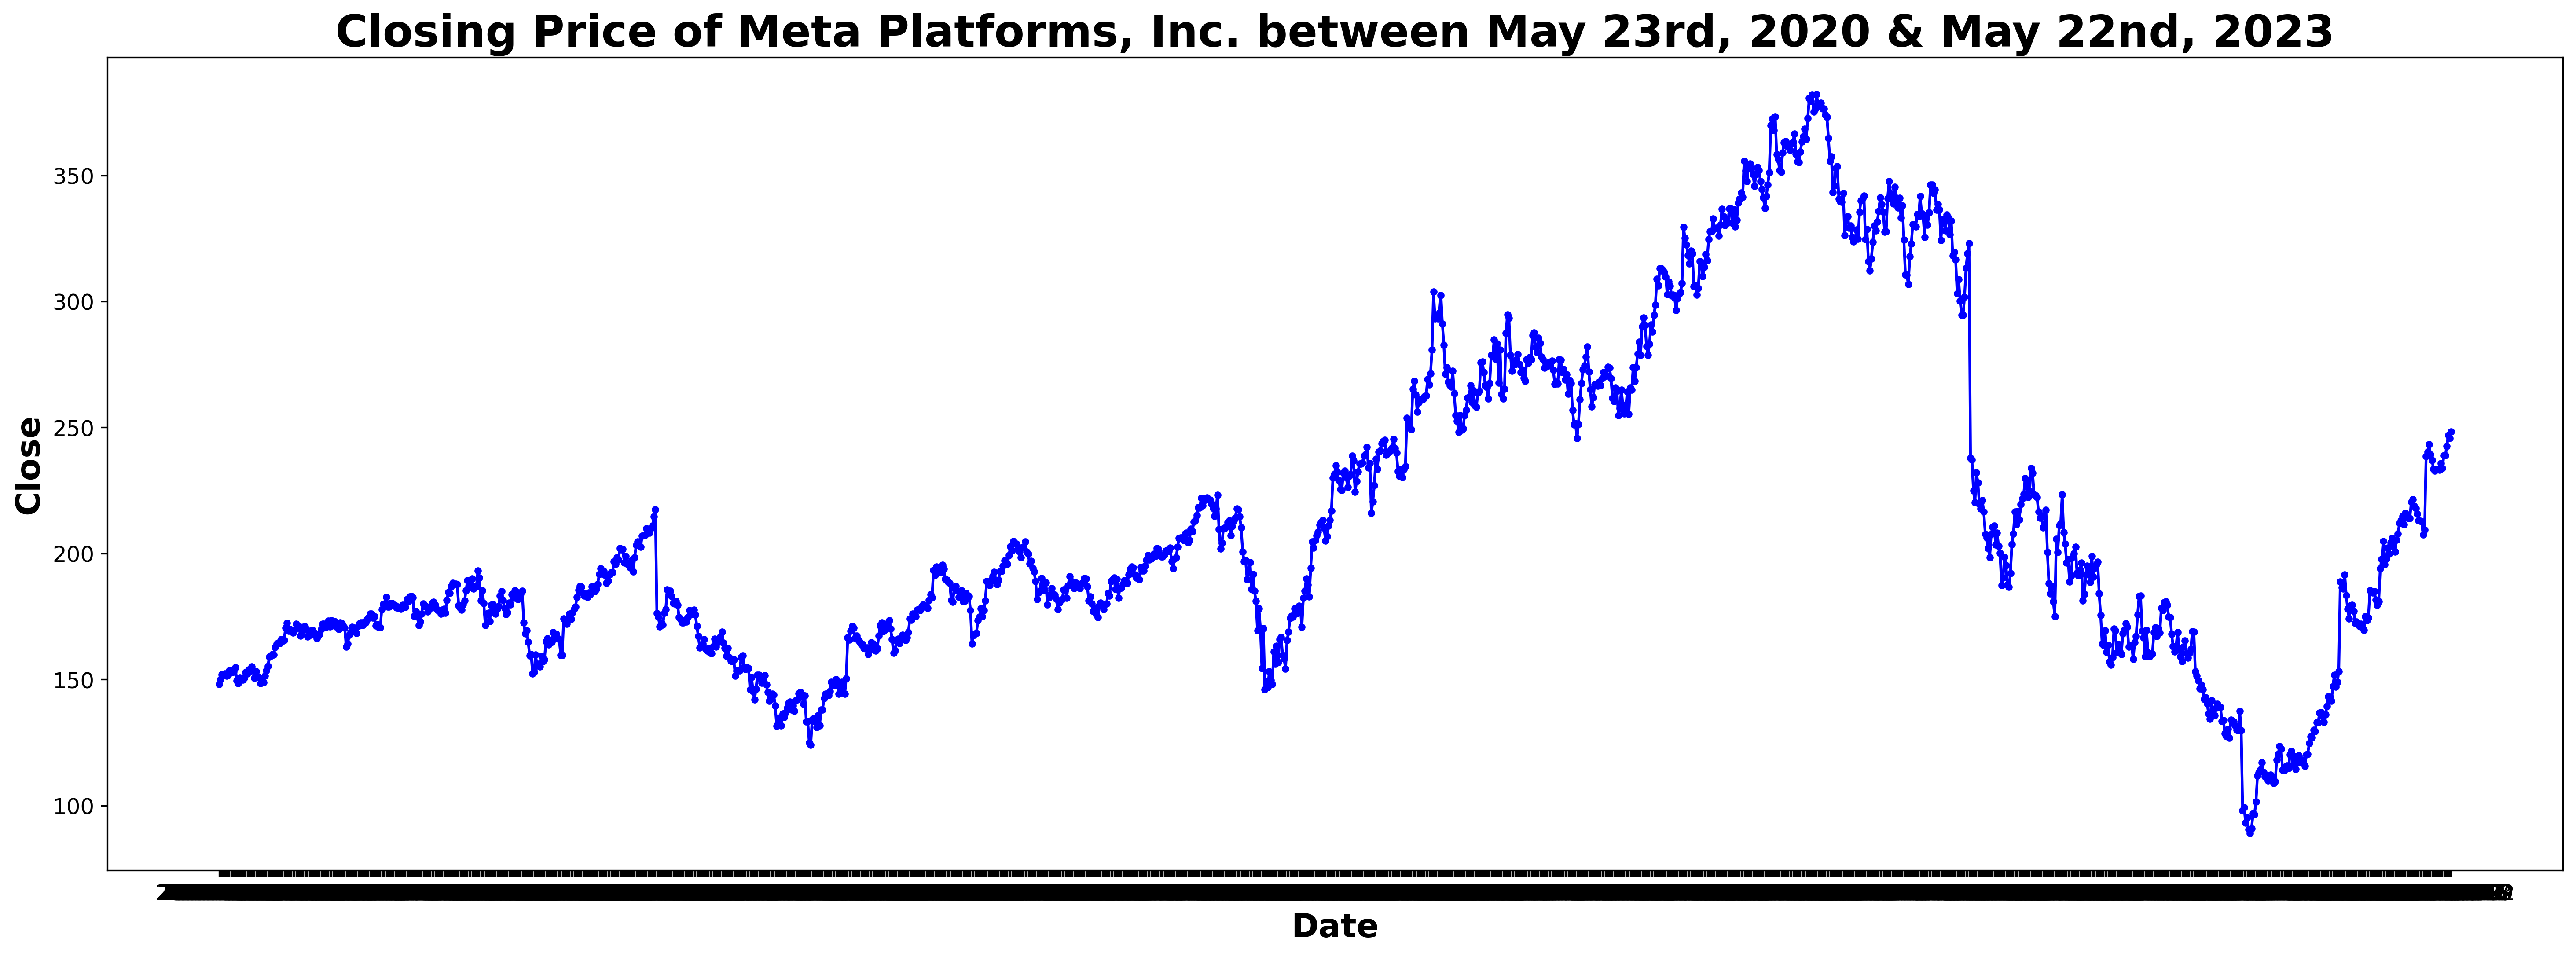

In [10]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Closing Price of Meta Platforms, Inc. between May 23rd, 2020 & May 22nd, 2023',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Close'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [11]:
# Create 3 lags
new_df['Lag_1']=new_df['Close'].shift(1).copy()
new_df['Lag_2']=new_df['Close'].shift(2).copy()
new_df['Lag_3']=new_df['Close'].shift(3).copy()
new_df.head()

,Date,Close,Lag_1,Lag_2,Lag_3
0,2017-05-23,148.070007,NaN,NaN,NaN
1,2017-05-24,150.039993,148.070007,NaN,NaN
2,2017-05-25,151.960007,150.039993,148.070007,NaN
3,2017-05-26,152.130005,151.960007,150.039993,148.070007
4,2017-05-30,152.380005,152.130005,151.960007,150.039993


In [12]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1,Lag_2,Lag_3
0,2017-05-26,152.130005,151.960007,150.039993,148.070007
1,2017-05-30,152.380005,152.130005,151.960007,150.039993
2,2017-05-31,151.460007,152.380005,152.130005,151.960007
3,2017-06-01,151.529999,151.460007,152.380005,152.130005
4,2017-06-02,153.610001,151.529999,151.460007,152.380005
...,...,...,...,...,...
1502,2023-05-16,238.820007,238.860001,233.809998,235.789993
1503,2023-05-17,242.490005,238.820007,238.860001,233.809998
1504,2023-05-18,246.850006,242.490005,238.820007,238.860001
1505,2023-05-19,245.639999,246.850006,242.490005,238.820007


In [13]:
# Colab
clean_df.to_csv('Meta_Lags.csv',index=False, header=True)

# 3. Data preprocessing under time-series structure

A total of 6 years are in the data set. In this practice, we will use the last one years of data as the testing set

In [14]:
# Train data
Forecast_train_data=clean_df.iloc[0:1257,:].copy()
Forecast_train_data

,Date,Close,Lag_1,Lag_2,Lag_3
0,2017-05-26,152.130005,151.960007,150.039993,148.070007
1,2017-05-30,152.380005,152.130005,151.960007,150.039993
2,2017-05-31,151.460007,152.380005,152.130005,151.960007
3,2017-06-01,151.529999,151.460007,152.380005,152.130005
4,2017-06-02,153.610001,151.529999,151.460007,152.380005
...,...,...,...,...,...
1252,2022-05-17,202.619995,200.039993,198.619995,191.240005
1253,2022-05-18,192.240005,202.619995,200.039993,198.619995
1254,2022-05-19,191.289993,192.240005,202.619995,200.039993
1255,2022-05-20,193.539993,191.289993,192.240005,202.619995


In [15]:
# Test data
Forecast_test_data=clean_df.iloc[1257:1257+250,:].copy()
Forecast_test_data

,Date,Close,Lag_1,Lag_2,Lag_3
1257,2022-05-24,181.279999,196.229996,193.539993,191.289993
1258,2022-05-25,183.830002,181.279999,196.229996,193.539993
1259,2022-05-26,191.630005,183.830002,181.279999,196.229996
1260,2022-05-27,195.130005,191.630005,183.830002,181.279999
1261,2022-05-31,193.639999,195.130005,191.630005,183.830002
...,...,...,...,...,...
1502,2023-05-16,238.820007,238.860001,233.809998,235.789993
1503,2023-05-17,242.490005,238.820007,238.860001,233.809998
1504,2023-05-18,246.850006,242.490005,238.820007,238.860001
1505,2023-05-19,245.639999,246.850006,242.490005,238.820007


# 4. Prepare time-series data for train/validation structure manually

Here we have a total of 18 years of data in training data set that are ready to be further splitted into training and validation data set

18 years of data can be evenlly divided into 6 portions (3 years in each portion)

# Expanding window

In [16]:
# Expanding 1
Exp_training_1=Forecast_train_data.iloc[0:33,:].copy()
Exp_val_1=Forecast_train_data.iloc[33:33+12,:].copy()

# Expanding 2
Exp_training_2=Forecast_train_data.iloc[0:45,:].copy()
Exp_val_2=Forecast_train_data.iloc[45:45+12,:].copy()

# Expanding 3
Exp_training_3=Forecast_train_data.iloc[0:57,:].copy()
Exp_val_3=Forecast_train_data.iloc[57:57+12,:].copy()

# Rolling window

In [ ]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:33,:].copy()
Rol_val_1=Forecast_train_data.iloc[33:33+12,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[9:45,:].copy()
Rol_val_2=Forecast_train_data.iloc[45:45+12,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[21:57,:].copy()
Rol_val_3=Forecast_train_data.iloc[57:57+12,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X) 

In [17]:
#set x (make prediction)
# Train
x_train=Exp_training_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_3['Close'].copy()
y_val=Exp_val_3['Close'].copy()

In [ ]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Close'].copy()
y_val=Rol_val_1['Close'].copy()

# 6. Creating Net 

In [18]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.146961,0.067027,0.000000
1,0.154039,0.146961,0.080803
2,0.164447,0.154039,0.159557
3,0.126145,0.164447,0.166530
4,0.129059,0.126145,0.176784


In [19]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [20]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.   

# Sequential style coding for creating net

In [21]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))

# Add fourth hidden layer
model.add(Dense(units=48, activation='linear'))

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.01,beta_1=0.8)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 1)                 49        
                                                                 
Total params: 1,669
Trainable params: 1,669
Non-trainable params: 0
_________________________________________________________________


Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [22]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=200, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 158.8653 - mean_absolute_percentage_error: 100.0422 - val_loss: 168.3586 - val_mean_absolute_percentage_error: 99.8317
Epoch 2/200
1/1 [==============================] - 0s 32ms/step - loss: 158.5209 - mean_absolute_percentage_error: 99.8298 - val_loss: 167.9984 - val_mean_absolute_percentage_error: 99.6181
Epoch 3/200
1/1 [==============================] - 0s 37ms/step - loss: 158.1724 - mean_absolute_percentage_error: 99.6147 - val_loss: 167.5559 - val_mean_absolute_percentage_error: 99.3556
Epoch 4/200
1/1 [==============================] - 0s 31ms/step - loss: 157.7400 - mean_absolute_percentage_error: 99.3476 - val_loss: 166.9698 - val_mean_absolute_percentage_error: 99.0080
Epoch 5/200
1/1 [==============================] - 0s 31ms/step - loss: 157.1687 - mean_absolute_percentage_error: 98.9945 - val_loss: 166.1778 - val_mean_absolute_percentage_error: 98.5383
Epoch 6/200
1/1 [==============================] - 

In [23]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

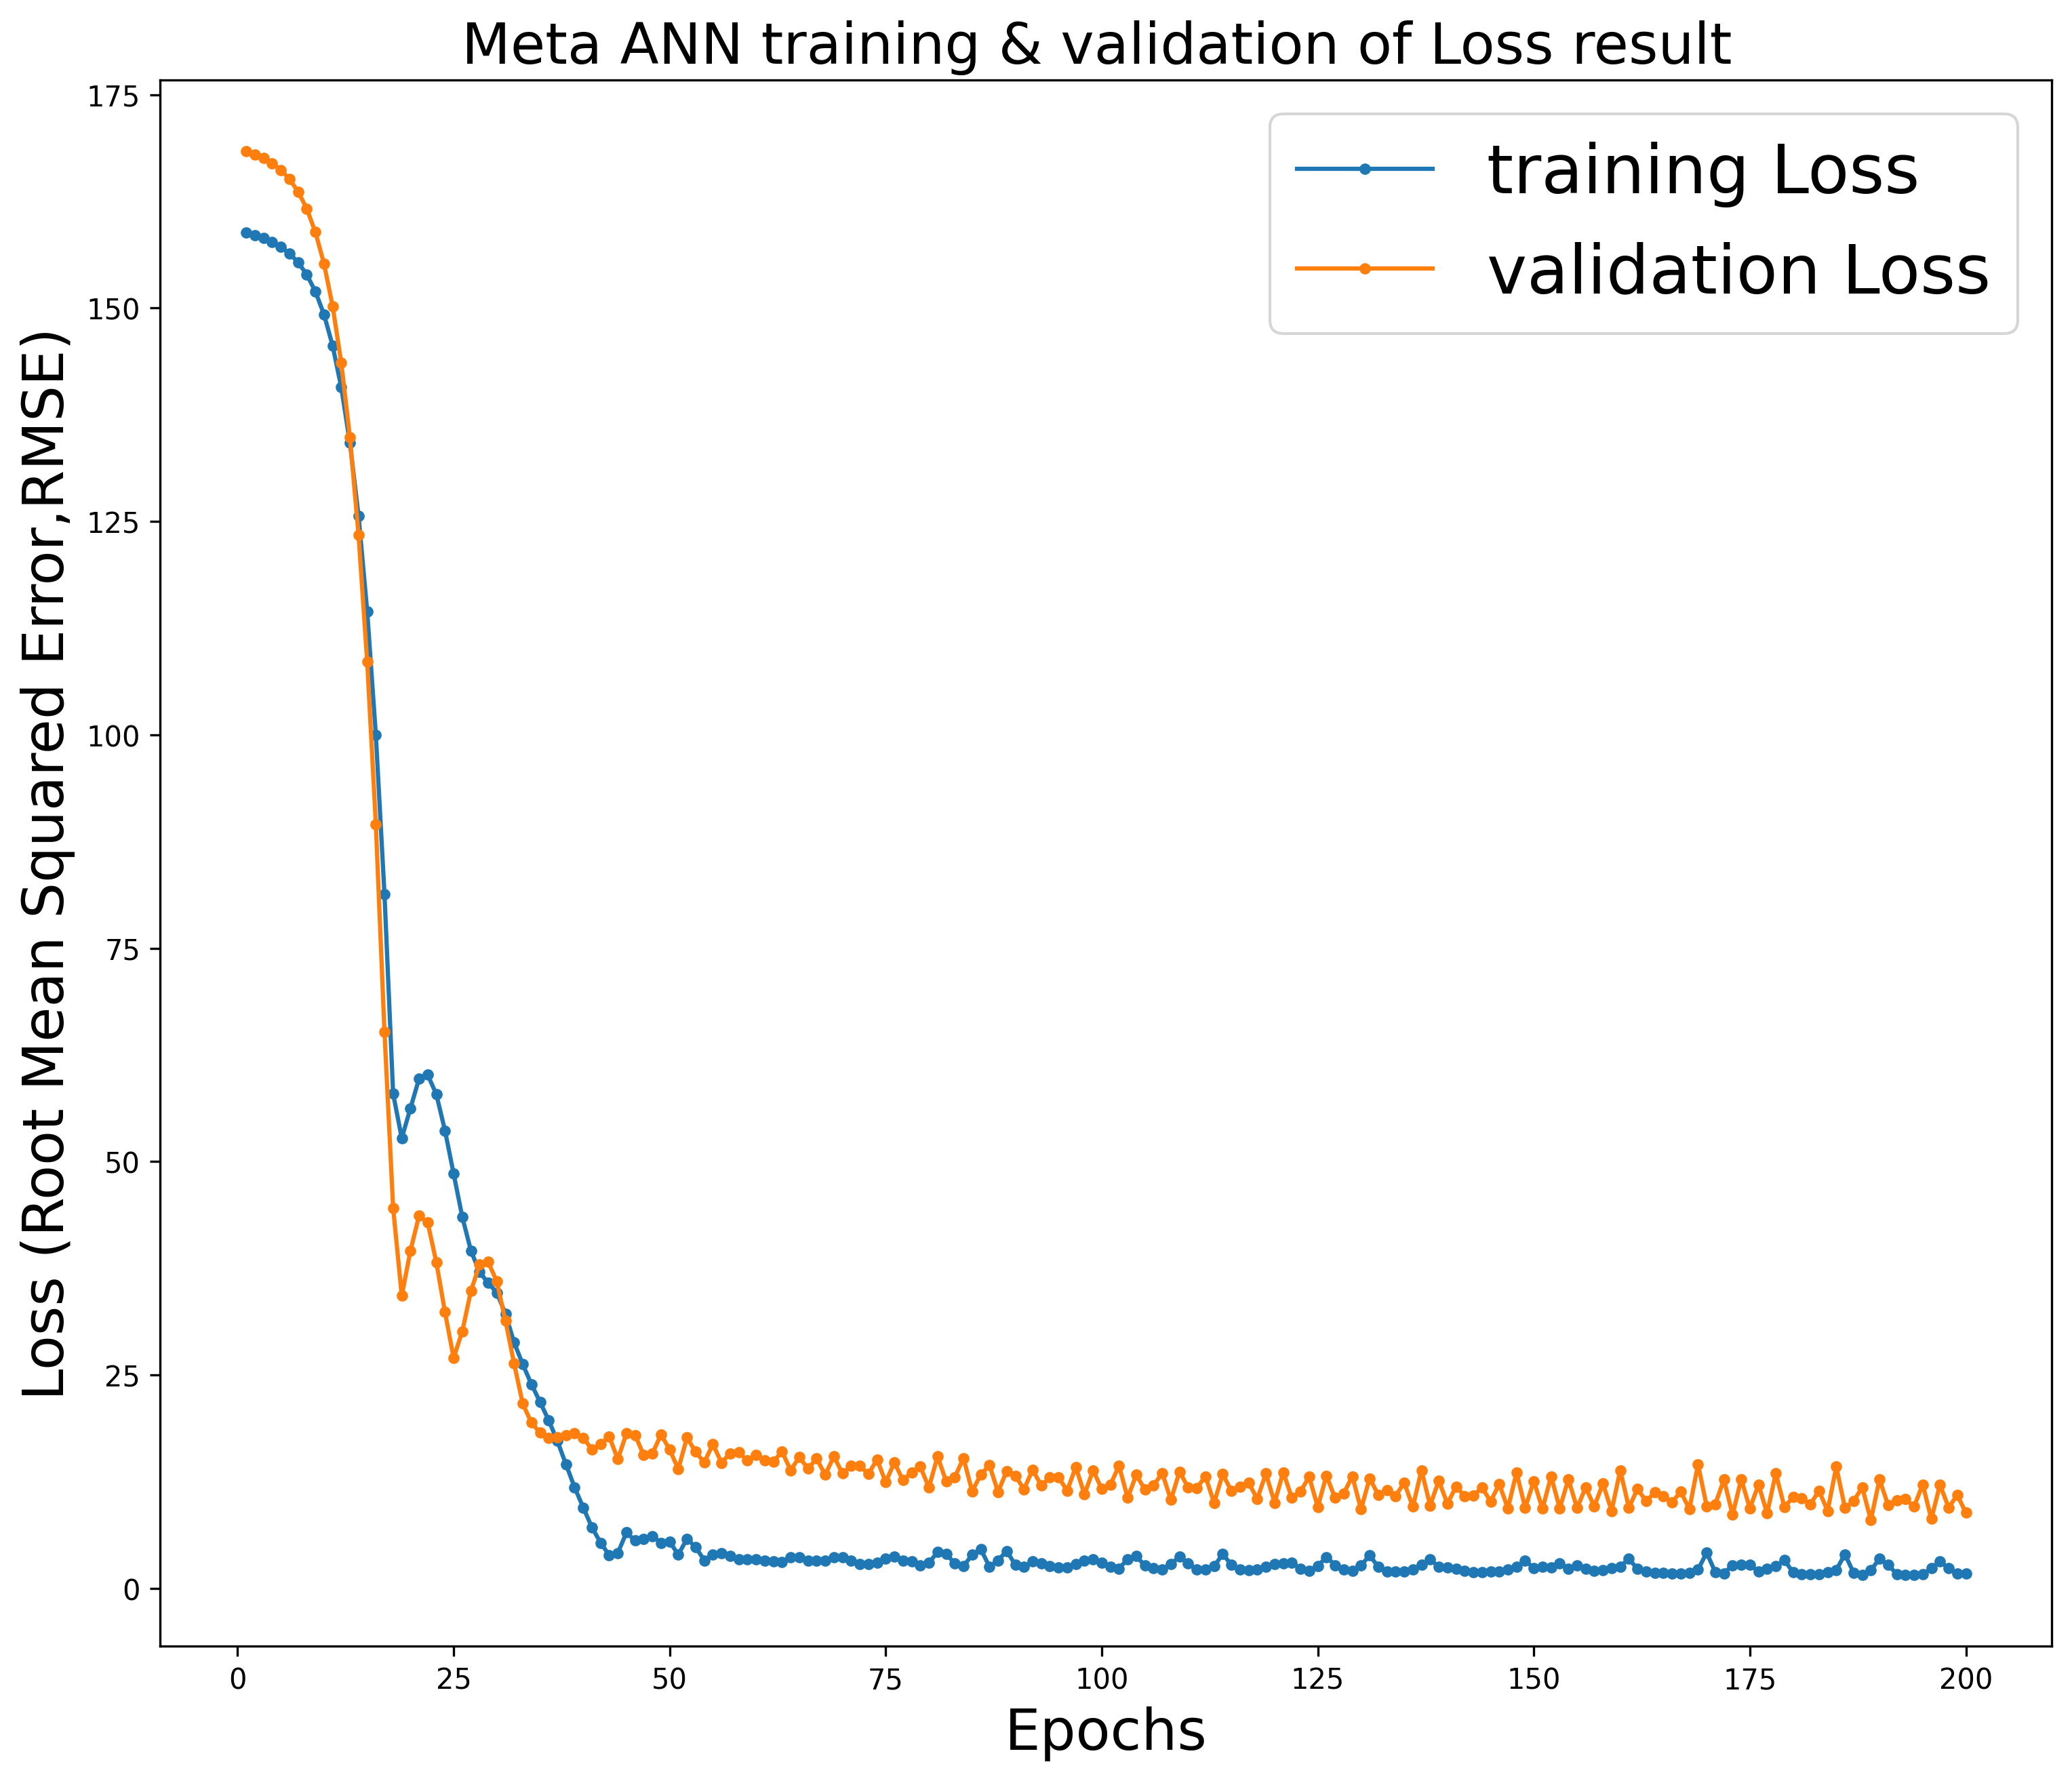

In [24]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Meta ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

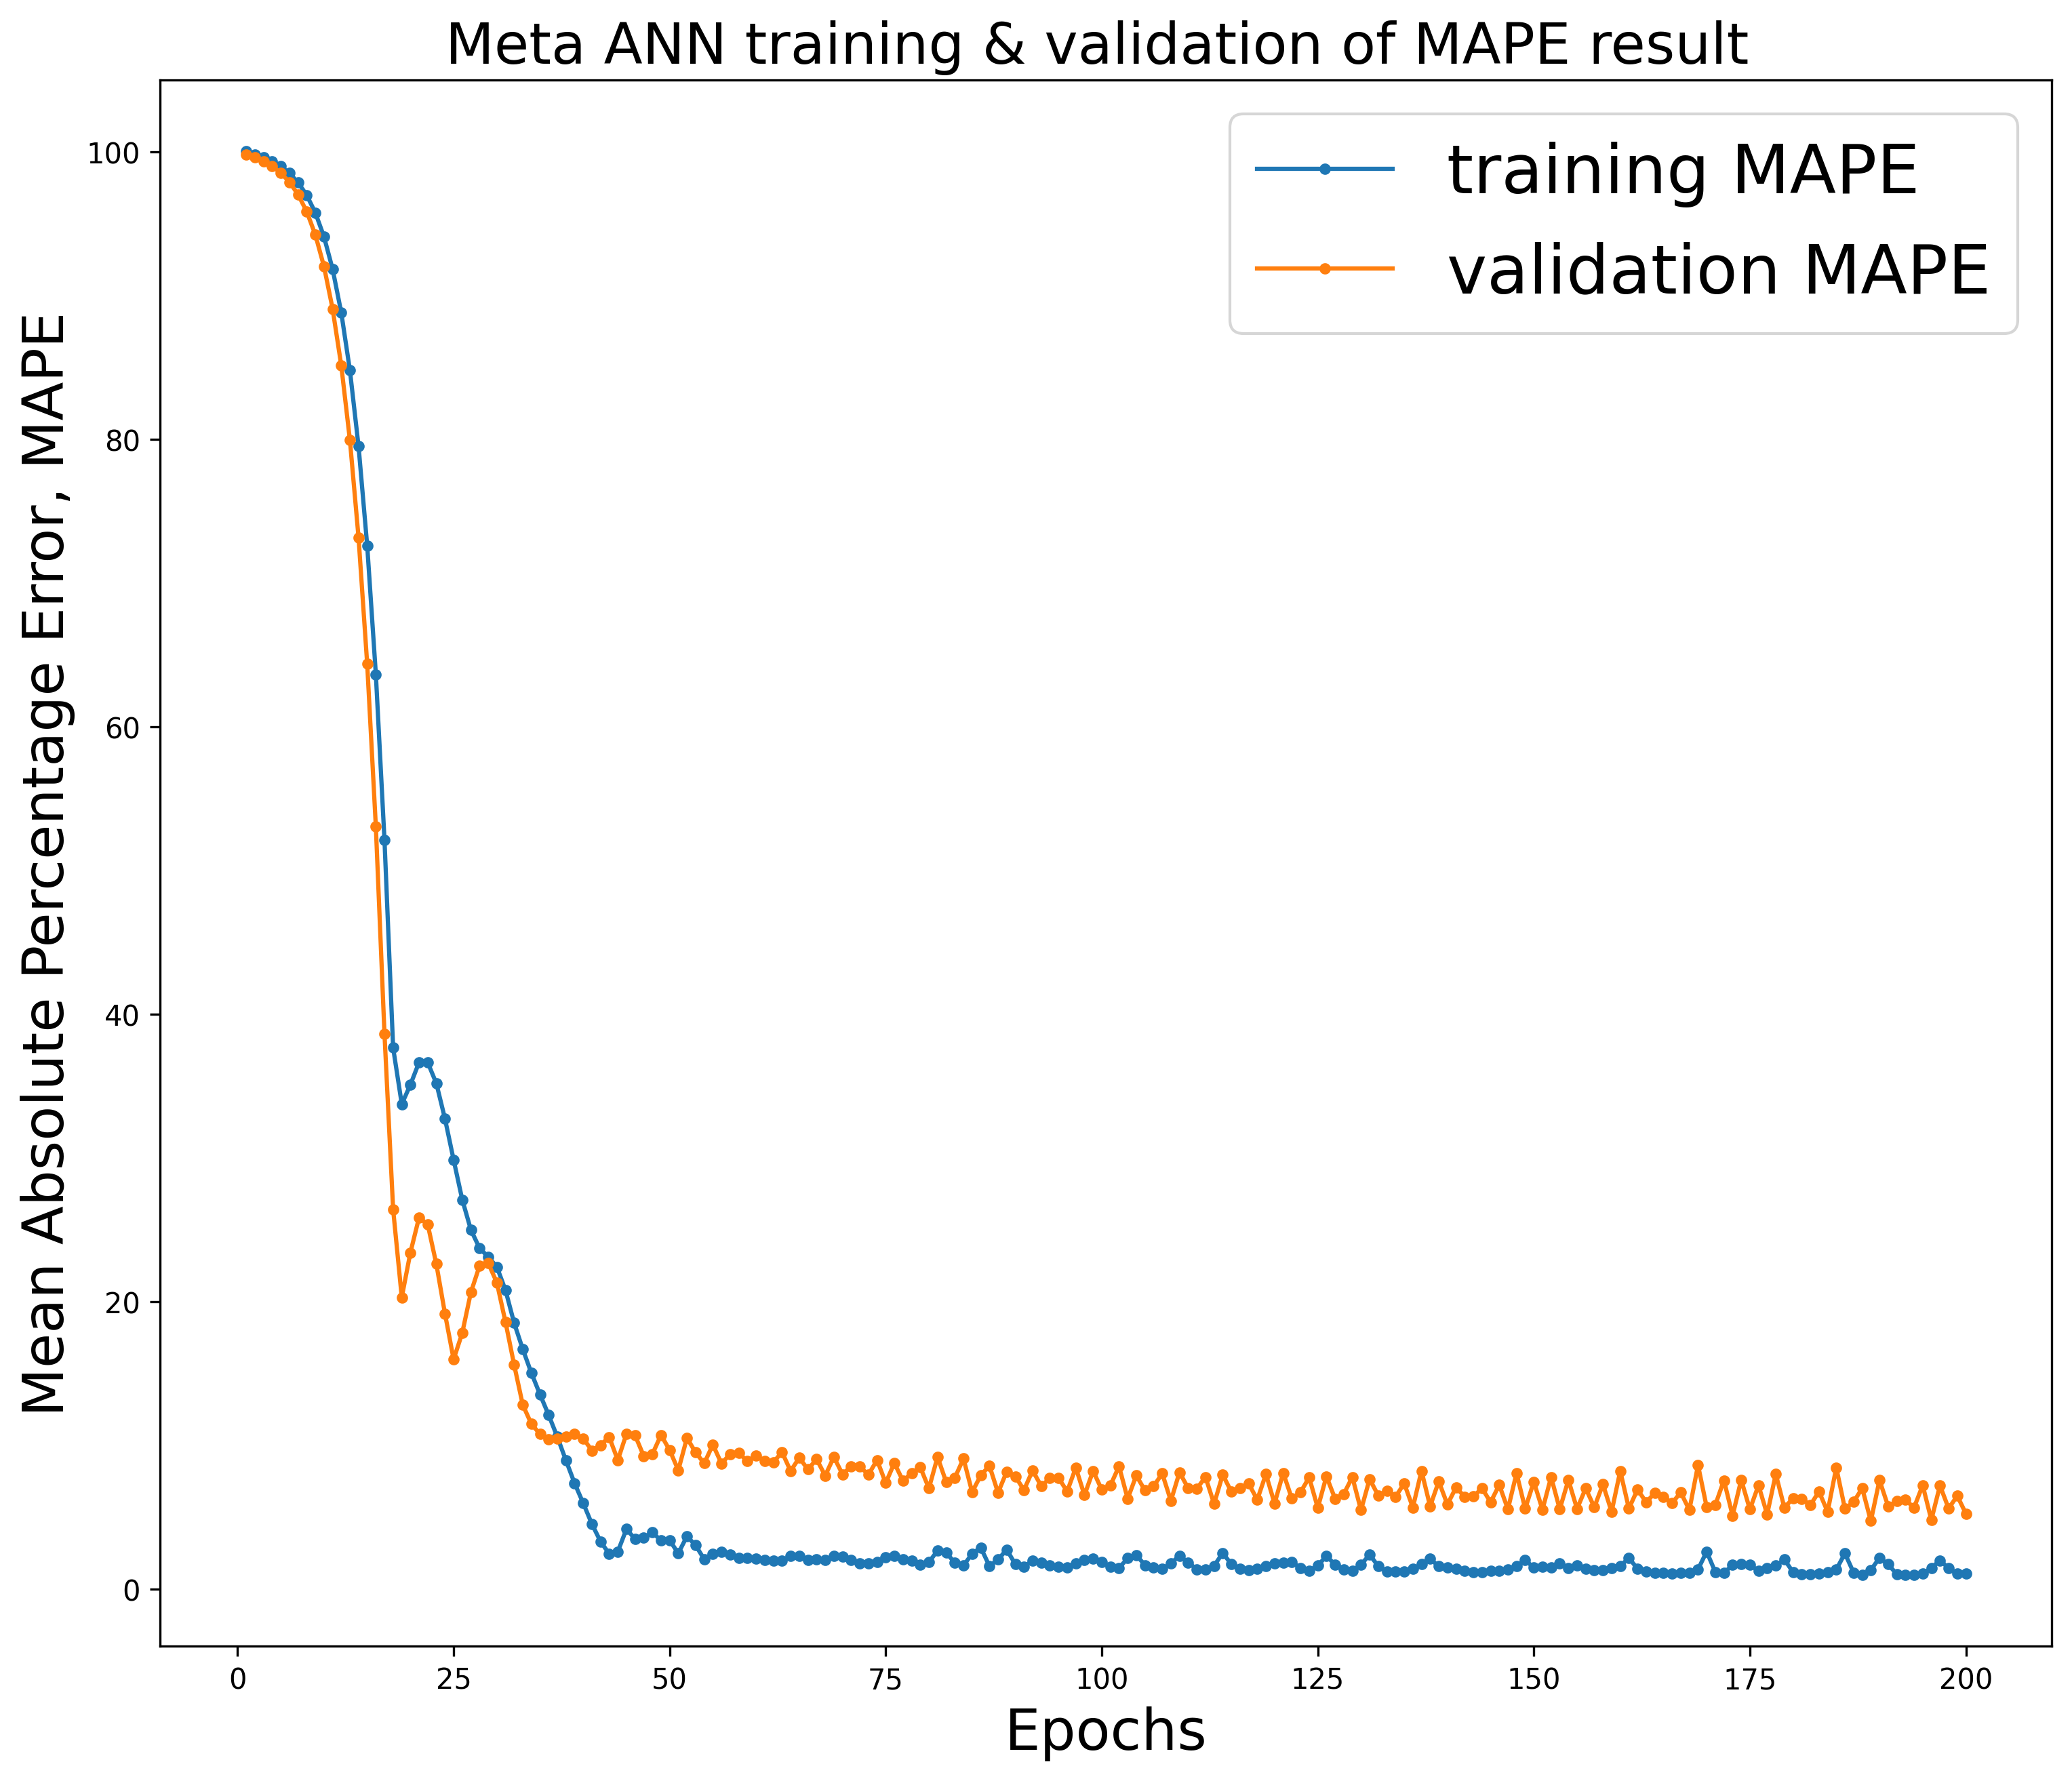

In [26]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Meta ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [27]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Close'].copy()

In [28]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# Add second hidden layer
Fmodel.add(Dense(units=12, activation='linear'))

# Add third hidden layer
Fmodel.add(Dense(units=24, activation='relu'))

# Add fourth hidden layer
Fmodel.add(Dense(units=48, activation='linear'))

# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.01,beta_1=0.8)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 1)                 49        
                                                                 
Total params: 1,669
Trainable params: 1,669
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=200, batch_size=64,verbose=1)

Epoch 1/200
20/20 [==============================] - 1s 4ms/step - loss: 40.9273 - mean_absolute_percentage_error: 18.5439
Epoch 2/200
20/20 [==============================] - 0s 4ms/step - loss: 6.6620 - mean_absolute_percentage_error: 3.0480
Epoch 3/200
20/20 [==============================] - 0s 4ms/step - loss: 7.4745 - mean_absolute_percentage_error: 3.3681
Epoch 4/200
20/20 [==============================] - 0s 4ms/step - loss: 10.6606 - mean_absolute_percentage_error: 4.8396
Epoch 5/200
20/20 [==============================] - 0s 4ms/step - loss: 9.2971 - mean_absolute_percentage_error: 4.2096
Epoch 6/200
20/20 [==============================] - 0s 4ms/step - loss: 7.7816 - mean_absolute_percentage_error: 3.5078
Epoch 7/200
20/20 [==============================] - 0s 4ms/step - loss: 5.7348 - mean_absolute_percentage_error: 2.6138
Epoch 8/200
20/20 [==============================] - 0s 4ms/step - loss: 7.3039 - mean_absolute_percentage_error: 3.3068
Epoch 9/200
20/20 [==========

In [30]:
# Colab
Fmodel.save('Meta_ANN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [31]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('Meta_ANN_trained_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [33]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Close'].copy()

In [34]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [36]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Close_true':Forecast_test_data['Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Close_true']-Results['Predict'])
Results

,Date,Close_true,Predict,abs Error
1257,2022-05-24,181.279999,195.949997,14.669998
1258,2022-05-25,183.830002,186.220001,2.389999
1259,2022-05-26,191.630005,182.160004,9.470001
1260,2022-05-27,195.130005,189.990005,5.140000
1261,2022-05-31,193.639999,195.229996,1.589997
...,...,...,...,...
1502,2023-05-16,238.820007,237.270004,1.550003
1503,2023-05-17,242.490005,239.399994,3.090011
1504,2023-05-18,246.850006,241.470001,5.380005
1505,2023-05-19,245.639999,246.020004,0.380005


In [37]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 4.123
MSE: 38.101
RMSE: 6.173
MAPE: 2.61 %
SMAPE: 2.597 %
RAE: 0.136
MRAE: 0.0005425223594584501
MdRAE: 0.103 bench: 163.447
RSE: 0.027
RRSE: 0.164


#  Plot for comparing true value & predicted value 

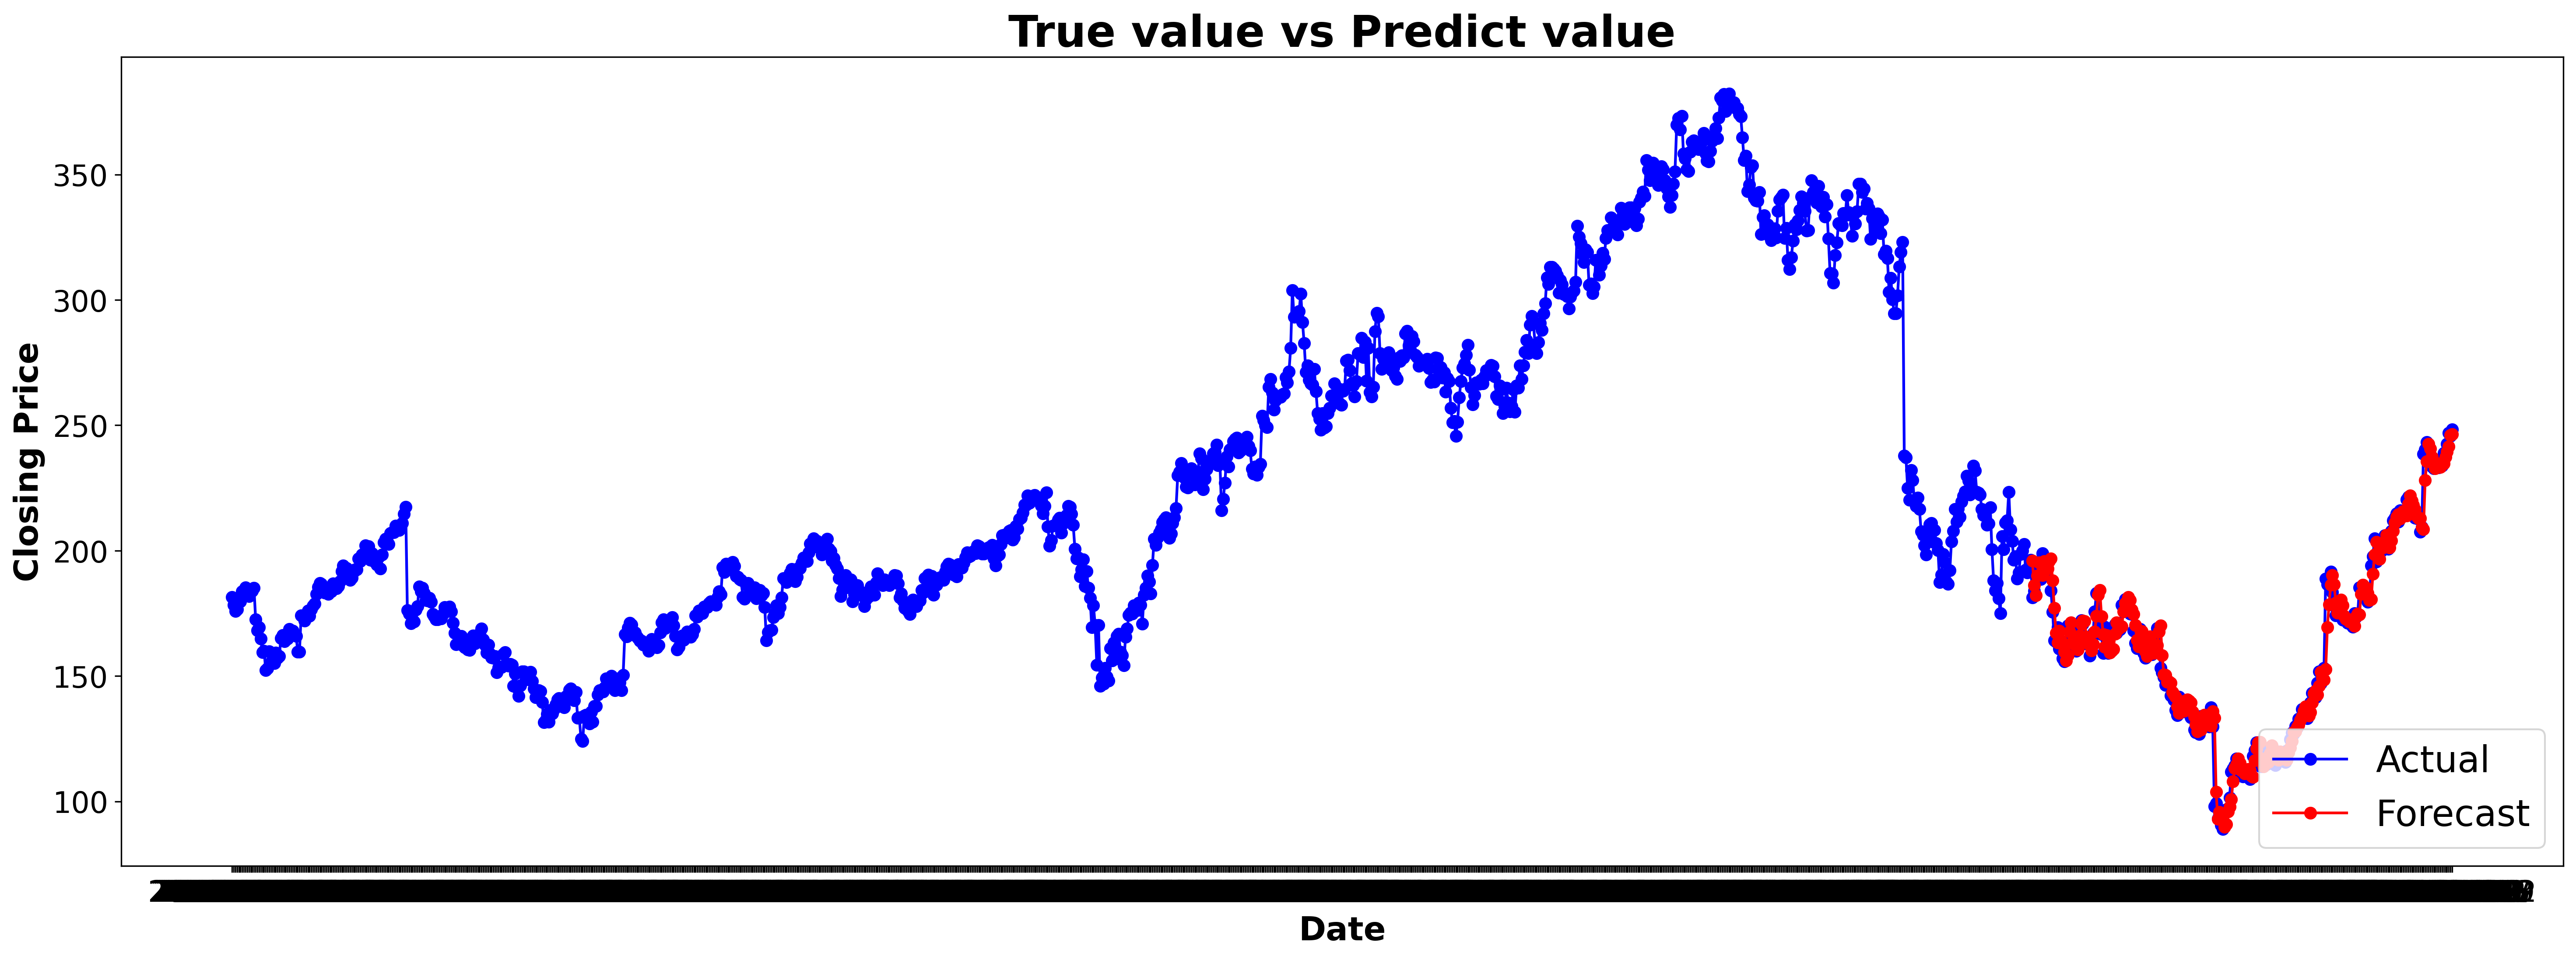

In [38]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('True value vs Predict value',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Closing Price',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[189:,0],clean_df.iloc[189:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

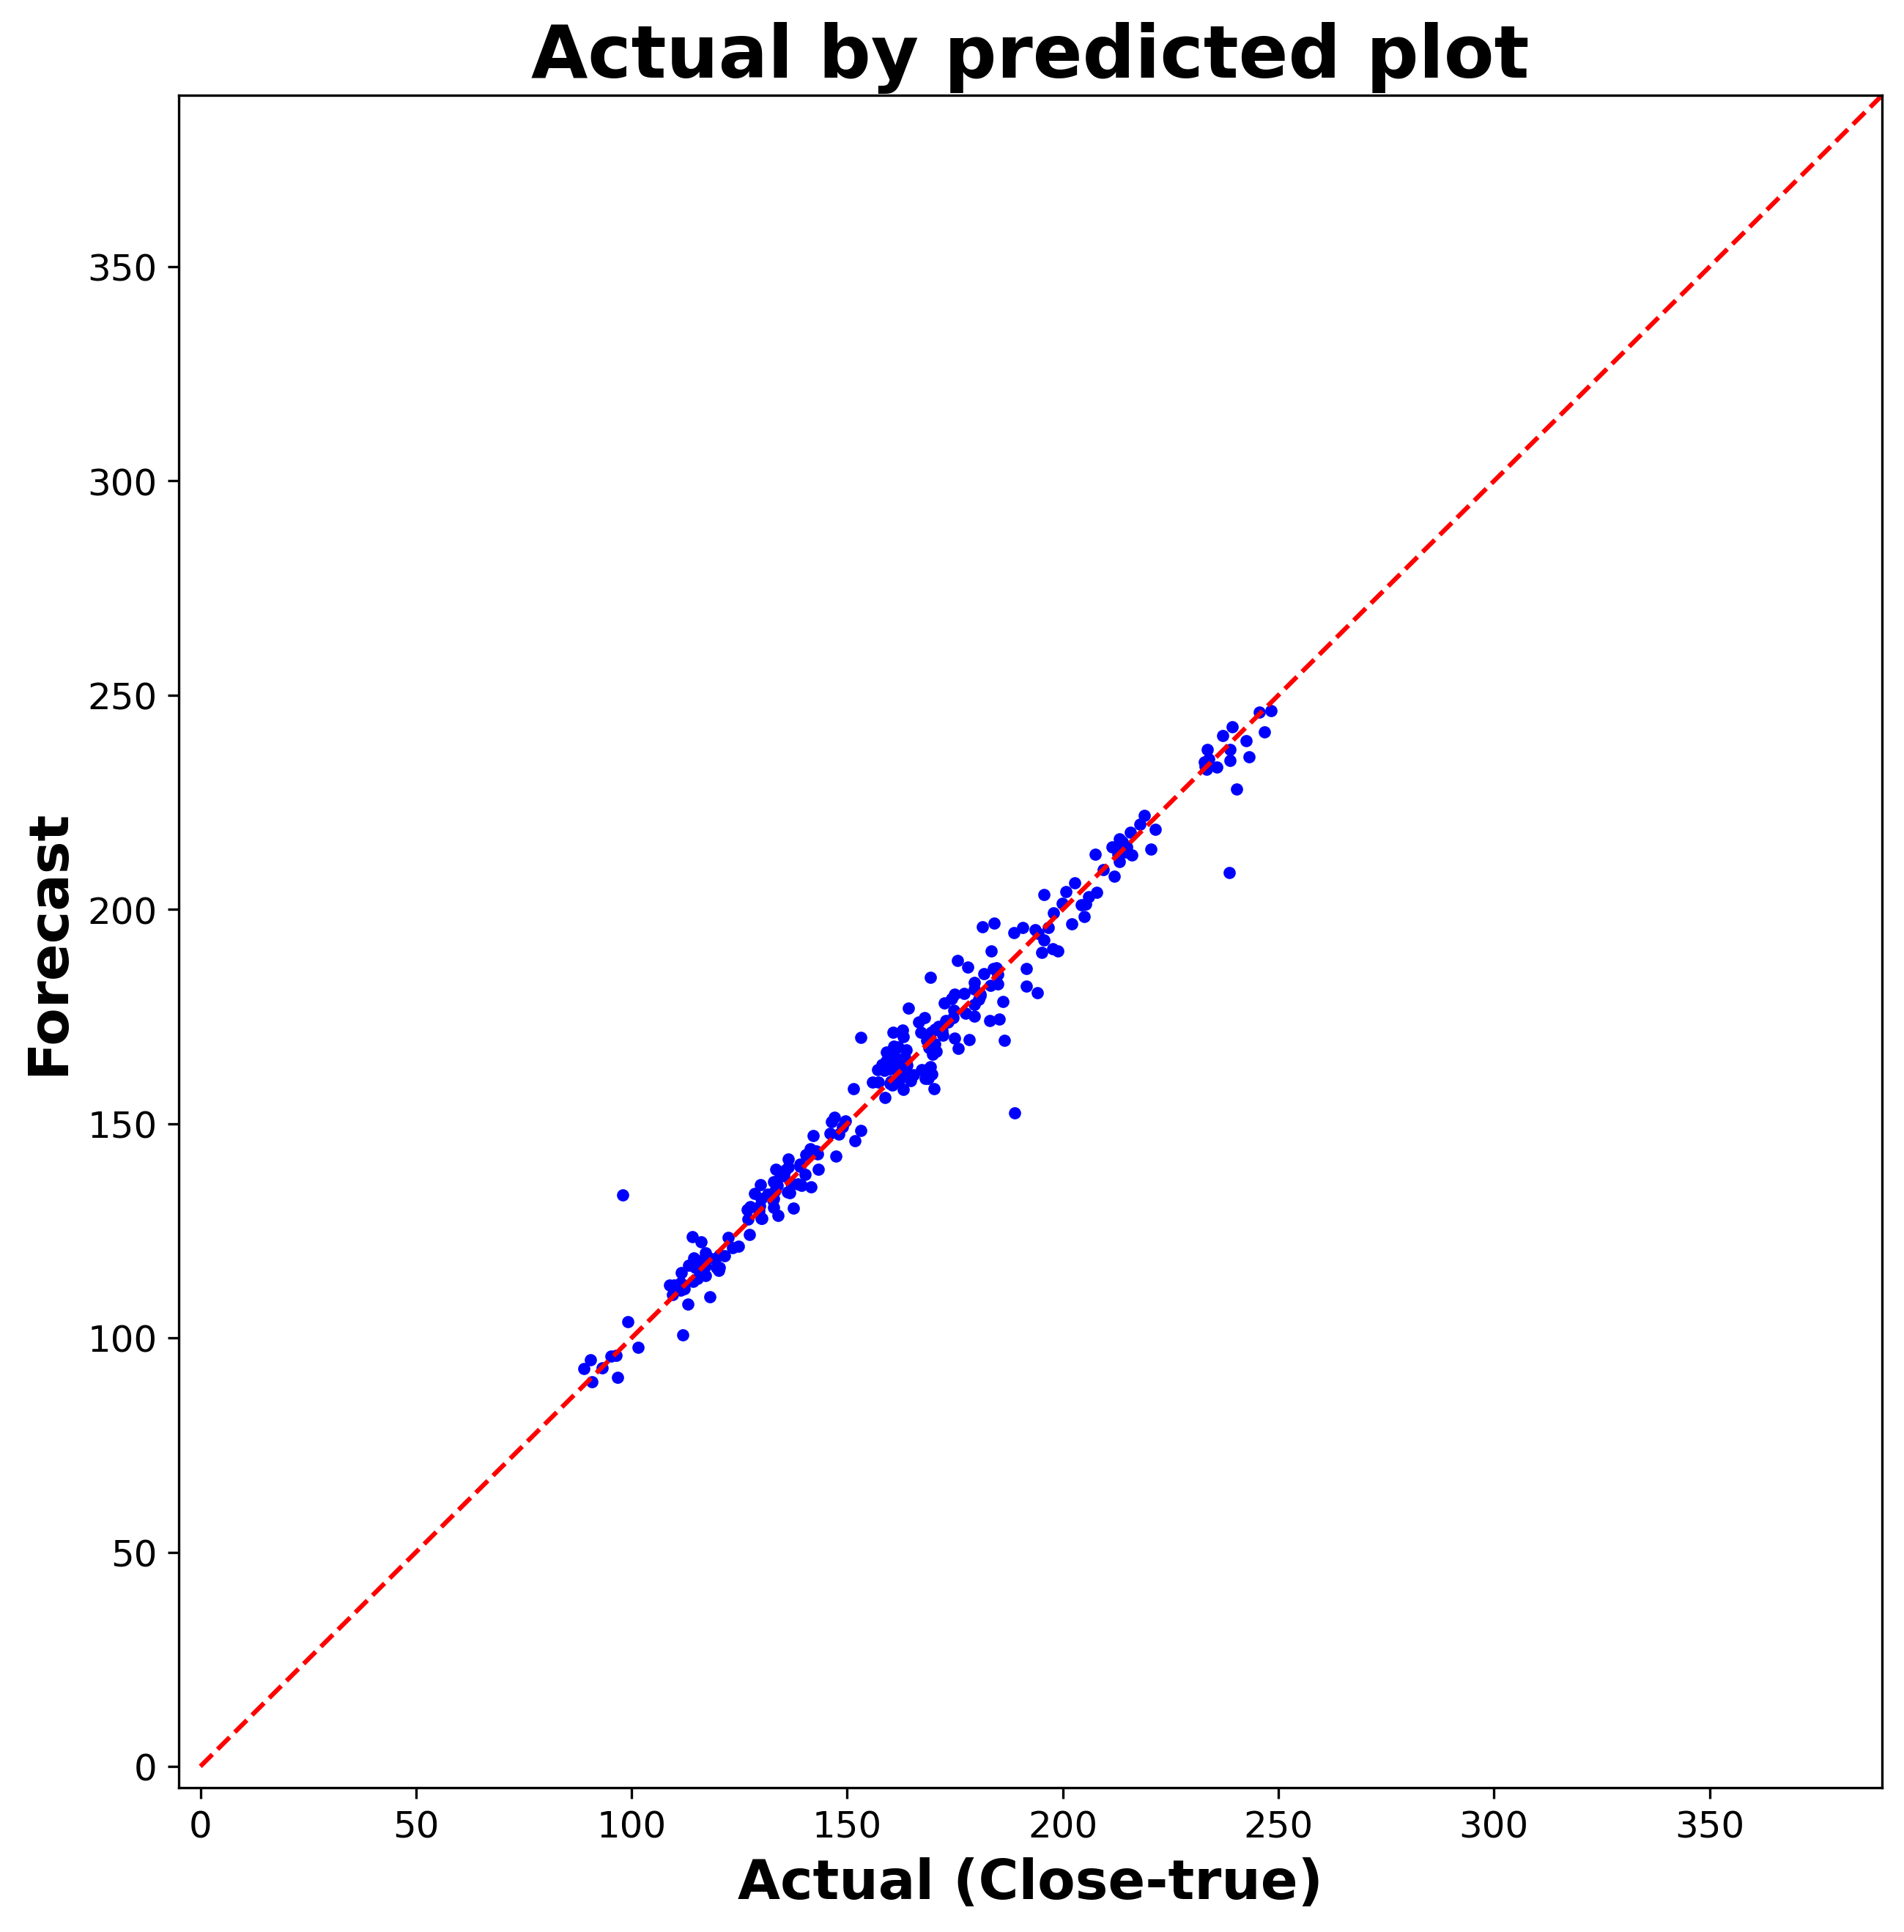

In [39]:
# Lock the scale of axis by Close_true
max_value=390
min_value=0

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Close-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()